In [1]:
import os
import math
import shap
import import_ipynb
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

In [14]:
# pip install ipynb
#pip install import-ipynb
%run Multiplex_function_library.ipynb

In [3]:
#Import datasets
global_dir_path = "C://Users/chris/OneDrive/Desktop/MIT postdoc project/ABN project/Lung cancer/Headspace_data"
#4wks
dir_path0 = global_dir_path + '/2023_0809_0810_Breath_EA_4w'
dir_path1 = global_dir_path + '/2023_1019_Breath_EA_4w'
#5wks
dir_path2 = global_dir_path + '/2024_0520_Breath_EA_5w'
dir_path3 = global_dir_path + '/2024_0619_Breath_EA_5w_Tx1'
dir_path4 = global_dir_path + '/2024_0621_Breath_EA_5w_Tx2'
#6wks
dir_path5 = global_dir_path + '/2024_0116_0117_Breath_EA_6w'
dir_path6 = global_dir_path + '/2024_0216_Breath_EA_6w'

In [4]:
#import excel files using panda as df
dict_name = {}
dict_name["name0"] = dir_path0 + '/Zscore_AUC10_30_4wks_080923.xlsx'
dict_name["name1"] = dir_path1 + '/Zscore_AUC10_30_4wks_101923.xlsx'
dict_name["name2"] = dir_path2 + '/Zscore_AUC10_30_5wks_052024.xlsx'
dict_name["name3"] = dir_path3 + '/Zscore_AUC10_30_5wks_061924.xlsx'
dict_name["name4"] = dir_path4 + '/Zscore_AUC10_30_5wks_062124.xlsx'
dict_name["name5"] = dir_path5 + '/Zscore_AUC10_30_6wks_011624.xlsx'
dict_name["name6"] = dir_path6 + '/Zscore_AUC10_30_6wks_021624.xlsx'

dict_df = {}
for i in range(0, len(dict_name)):
    dict_df["df"+ str(i)] = pd.read_excel(dict_name["name" + str(i)])

In [5]:
df_4w = pd.concat([dict_df["df0"], dict_df["df1"]], axis=0, ignore_index=True)
df_5w = pd.concat([dict_df["df2"], dict_df["df3"], dict_df["df4"]], axis=0, ignore_index=True)
df_6w = pd.concat([dict_df["df5"], dict_df["df6"]], axis=0, ignore_index=True)
# df_4w

In [6]:
lb_4w = class_label(df_4w)
lb_5w = class_label(df_5w)
lb_6w = class_label(df_6w)

In [7]:
# Use random search to find the best hyperparameters
# Only do when optimizing the parameters
param_dist = {'n_estimators': [100, 500, 1000],
                'max_depth': stats.randint(1,10),
                 'min_samples_leaf' : stats.randint(1, 5), 
                  'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0],
                  'max_features' : ['sqrt', 'log2', 0.2, 0.4, 0.6, 0.8]}

#'criterion' : ['friedman_mse', 'squared_error']
clf = GradientBoostingClassifier()

rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_dist,
                                n_iter=10) #try also n_iter=10

In [8]:
# Fit the random search object to the data
result = test_train_split(df_4w, 0.35) #hard code the dataset of interest
    
rand_search.fit(result[20], result[21]) # hyperparameter search on the training sets (X_train_all, y_train_all)

best_clf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'learning_rate': 0.8, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 100}


In [10]:
#Hard code for each week
#4wks
clf_4w = GradientBoostingClassifier(n_estimators=1000, max_depth=3, max_features='sqrt',
                                 random_state=42, min_samples_leaf=3, criterion='friedman_mse', 
                                 learning_rate=0.8).fit(test_train_split(df_4w, 0.35)[20], test_train_split(df_4w, 0.35)[21])

#5wks
clf_5w = GradientBoostingClassifier(n_estimators=100, max_depth=6,
                                 max_features = 'log2', criterion= 'friedman_mse',
                                 random_state=42, min_samples_leaf=1,
                                 learning_rate=0.1).fit(test_train_split(df_5w, 0.35)[20], test_train_split(df_5w, 0.35)[21])

#6wks
clf_6w = GradientBoostingClassifier(n_estimators=100, max_depth=6,
                                 max_features = 0.4, criterion= 'friedman_mse',
                                 random_state=42, min_samples_leaf=1,
                                 learning_rate=0.1).fit(test_train_split(df_6w, 0.35)[20], test_train_split(df_6w, 0.35)[21])

In [11]:
model_accuracy(df_4w, clf_4w, 0.35)
model_accuracy(df_5w, clf_5w, 0.35)
model_accuracy(df_6w, clf_6w, 0.35)

MODEL ACCURACY:  0.5
MODEL ACCURACY:  0.6190476190476191
MODEL ACCURACY:  0.5714285714285714


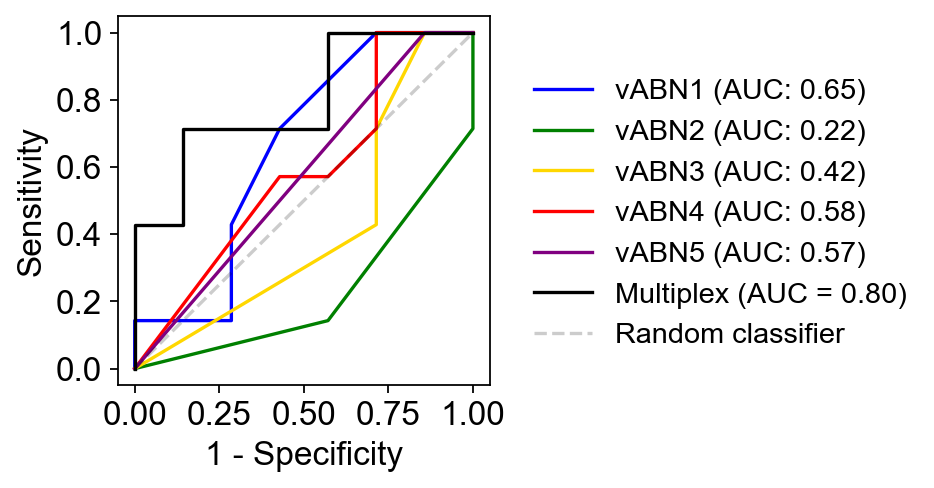

In [15]:
plot_roc_allns(df_4w, clf_4w, 0.35)
# plot_roc_allns(df_5w, clf_5w)
# plot_roc_allns(df_6w, clf_6w)

In [ ]:
# plot_roc_allwks(df_4w, df_5w, df_6w, clf_4w, clf_5w, clf_6w)